In [1]:
import os
os.chdir('../src')

In [2]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

## Regression

Theoretically optimizing the log-return accuracy should be equivalent to optimizing the expected log-returns and thus equivalent to optimizing the returns. Thus, returns-wise it might be a better idea to use regression.

In [20]:
featureset = 'indicators1'

df = pd.read_hdf('../data/features/technical.h5', key=featureset)
df['preds'] = pd.read_hdf('../data/predictions/regression_{}.h5'.format(featureset), key='predictions').shift()
df.preds = df.preds

rolling_period = 200
steps_ahead = 4
df['adjusted_preds'] = df.target.rolling(rolling_period).std() * df.preds
df.target = df.target.rolling(steps_ahead).sum().shift(1-steps_ahead)

df = df.dropna()

print(metrics.accuracy_score(df.target > 0, df.preds.shift(-1) > 0))

metrics.r2_score(df.target, df.adjusted_preds)

0.5214508909720463


0.00691834041268935

The $R^2$ score should be invariant to the sampling frequency, since increasing it will only improve the MSE and the variance estimates. I guess $R^2$ actually can be thought of as some kind of *explained signal to noise ratio*.

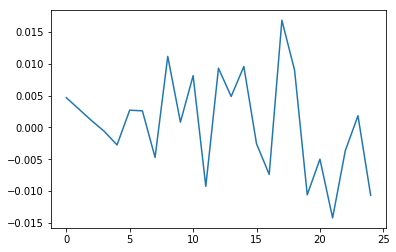

In [16]:
pd.Series(list(map(lambda steps_ahead: metrics.r2_score(df.target[::steps_ahead], df.adjusted_preds[::steps_ahead]), range(1,100, 4)))).plot()

This is so stupidly unrobust... At least you see how the variance gets smaller and smaller as the number of samples increases, which is what I predicted.

In [17]:
(df.target > 0).sum() / len(df)

0.5148986386816706

In [47]:
df.preds.std()

0.1913316983939531

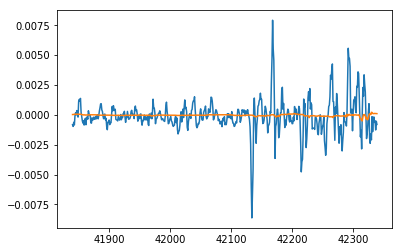

In [21]:
df.target[30000:30500].plot()
(df.adjusted_preds)[30000:30500].plot()

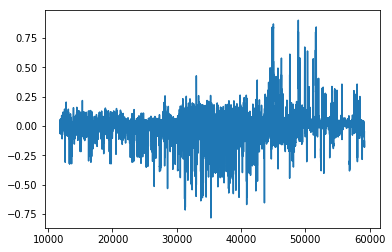

In [24]:
df.preds.plot()

Nice predictor we got here. At least it's not overfitting. The little accuracy performance we got was due to me dividing by the rolling standard deviation.

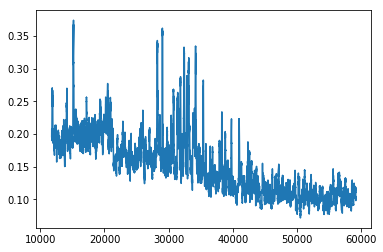

In [60]:
df.preds.rolling(100).std().plot()

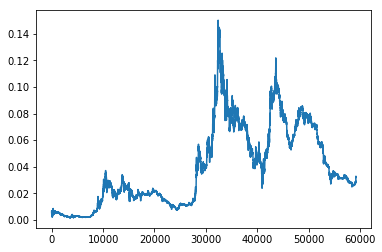

In [12]:
prices = pd.read_json('../data/raw/BTC_ETH.json')
prices.close.plot()

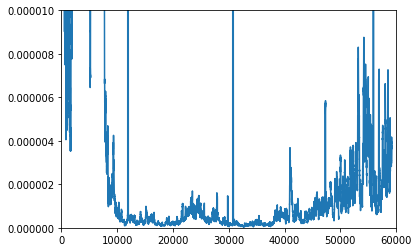

In [13]:
prices['log_diff'] = np.log(prices.close) - np.log(prices.close.shift(-1))
ax = plt.gca(xlim=(1, 60000), ylim=(0, 0.00001))
(np.square(prices.log_diff) / prices.volume).rolling(100).mean().plot()

My hypothesis is that total volume in bitcoin and volatility is very correlated, and that the graph above shows that poloniex did have a smaller share of the volume pie in the beginning and at the end, so the quotient doesn't perfectly match up.

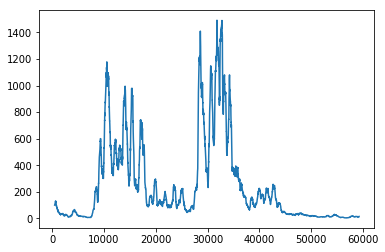

In [14]:
prices.volume.rolling(500).mean().plot()

## Proper Normalization

Through which lens can we look at the data such that it has the nicest statistical properties possible? This question is especiallyl crucial for such notoriously noisy and unpredictable data. The goal here is to do regression, but if you look at the regression notebook you will see that the price norms are all over the place and the predictions are very close to the mean. This changes if you divide the target by the rolling standard deviation and you go from 51.4% accuracy on the sign of the prediction to 53.2%. It doesn't matter if you do this to the features.


What we basically want to minimize is the local and global standard deviation of log-diff^2. How does a rolling average affect this?


global std: 4.878865602063849
local std: 2.345057301790629


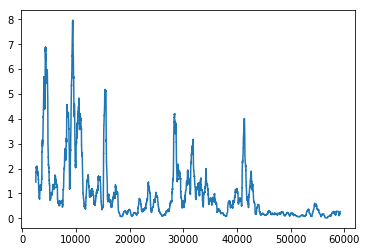

In [15]:
p_squared = np.square(prices.log_diff[2000:] / prices.log_diff[2000:].std())
p_squared.rolling(500).mean().plot() # note the high rolling frame period
print('global std:', pd.Series(p_squared).std())
print('local std:', pd.Series(p_squared).rolling(100).std().mean())

global std: 1.9862657251083975
local std: 1.9334807337311726


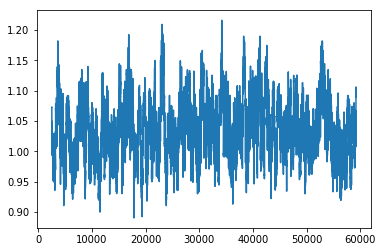

In [172]:
s = prices.log_diff[2000:]
s = s / s.rolling(25).std()
s_squared = pd.Series(np.square(s))
s_squared.rolling(500).mean().plot()

print('global std:', pd.Series(s_squared).std())
print('local std:', pd.Series(s_squared).rolling(100).std().mean())

Basically we have removed large norm deviations. But it definetly feel very forced, because we are straight up fabricating the new target. What if we used candles that dependende on the trade volume and not on time? This would seem very intuitive, because price action is **very** dense on the *hype zone*, see volume graph above and it does not compare to the other historical values. Maybe on the days where "nothing happens", one can actually not predict anything and on the extreme days one would profit from a more granular approach. First we granular data of a big chunk of ethereum history and a good estimate for the total volume in this asset class.

In [16]:
a = df[:10]
a.target
b = df[5:20]
a.combine_first(b)

target  BBANDS_up_0.5std  BBANDS_down_0.5std  BBWIDTH_0.5std  \
11608  0.000082             False               False        0.000298   
11609  0.000253             False               False        0.000247   
11610 -0.000216             False                True        0.000317   
11611  0.000128             False               False        0.000269   
11612  0.000005             False               False        0.000239   
11613  0.000000             False                True        0.000000   
11614  0.000009             False                True        0.000000   
11615  0.000152             False                True        0.000000   
11616  0.000089             False                True        0.000000   
11617 -0.000173             False                True        0.000206   
11618 -0.000059              True               False        0.000000   
11619  0.000328              True               False        0.000000   
11620 -0.000048             False                True        0.000235   
11621  0.000026             False               False        0.000256   
11622 -0.000348             False               False        0.000274   
11623 -0.000959              True               False        0.000322   
11624 -0.000040              True               False        0.001012   
11625  0.000110              True               False        0.001204   
11626  0.000004             False               False        0.001124   
11627 -0.000183             False               False        0.000751   

       HT_TREND_/      EMA/  SAR_Signal    ADX_0.5   APO_0.5    AROON_up  \
11608    0.996189  0.992443       False  39.423713  0.000082   57.142857   
11609    0.993160  0.989861       False  35.570254  0.000072   50.000000   
11610    0.983005  0.981020       False  36.833520  0.000091   42.857143   
11611    0.991778  0.990331       False  38.725967  0.000092   35.714286   
11612    0.987256  0.986142       False  39.423254  0.000097   28.571429   
11613    0.988048  0.986837       False  40.490430  0.000036   21.428571   
11614    0.989797  0.987675       False  38.845330 -0.000024   14.285714   
11615    0.991856  0.988124       False  36.141586 -0.000070    7.142857   
11616    0.988360  0.983150       False  37.166287 -0.000054    0.000000   
11617    0.986819  0.980864       False  33.955588 -0.000103    7.142857   
11618    0.995327  0.988613       False  30.370919 -0.000101    0.000000   
11619    0.998728  0.991567       False  26.208830 -0.000107   42.857143   
11620    0.986095  0.979694       False  27.711831 -0.000114  100.000000   
11621    0.988405  0.982799       False  29.000118 -0.000120   92.857143   
11622    0.987788  0.982905       False  27.849208 -0.000109   85.714286   
11623    1.002155  0.997201       False  23.980953 -0.000072   78.571429   
11624    1.040545  1.033668       False  28.317644  0.000040   71.428571   
11625    1.040683  1.032934       False  33.133007  0.000135   64.285714   
11626    1.034565  1.026608       False  37.260460  0.000275   57.142857   
11627    1.032810  1.024718       False  38.067732  0.000406   50.000000   

         ...        PPO_2    ROCR_2      RSI_2  STOCHRSI_k_2  STOCHRSI_d_2  \
11608    ...    -1.839475  0.969277  42.735499     90.652541  8.918859e+01   
11609    ...    -1.841288  0.964591  41.875333     72.470998  8.770785e+01   
11610    ...    -1.846187  0.956199  39.337832     24.199228  6.244092e+01   
11611    ...    -1.857074  0.968222  42.425523     77.490274  5.805350e+01   
11612    ...    -1.892152  0.975477  41.138705     53.003238  5.156425e+01   
11613    ...    -1.934235  0.991048  41.088220     56.689237  6.239425e+01   
11614    ...    -1.962864  0.994577  41.088220     56.689237  5.546057e+01   
11615    ...    -1.984150  0.987064  40.991167      0.000000  3.779282e+01   
11616    ...    -1.984154  0.988502  39.357175      0.000000  1.889641e+01   
11617    ...    -1.974413  0.980655  38.428462      0.000000  2.178998e-13   
11618    ...    -1.9